In [75]:
import json
import pandas as pd    

# json_file = "KindleStoreReviews.json"
json_file = "HomeKitchenReviews.json"
df = pd.read_json(json_file,lines=True)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5,Best Price,1382140800,"10 19, 2013"
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5,zoku,1403049600,"06 18, 2014"
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,"05 5, 2013"
3,A2MHCTX43MIMDZ,0615391206,"M. Johnson ""Tea Lover""","[14, 18]",This book is a must have if you get a Zoku (wh...,5,Creative Combos,1312416000,"08 4, 2011"
4,AHAI85T5C2DH3,0615391206,PugLover,"[0, 0]",This cookbook is great. I have really enjoyed...,4,A must own if you own the Zoku maker...,1402099200,"06 7, 2014"


In [76]:
df_copy = df.copy()

In [77]:
df['helpful_1'] = [l[0] for l in df['helpful']]
df['helpful_2'] = [l[1] for l in df['helpful']]
df['helpfulness'] = df['helpful_1']/df['helpful_2']

df = df[df['helpfulness'].notna()]

df['helpful_category'] = df['helpfulness'].map(lambda x: 1 if x>=0.5 else 0)

array([[<AxesSubplot:title={'center':'overall'}>,
        <AxesSubplot:title={'center':'unixReviewTime'}>],
       [<AxesSubplot:title={'center':'helpful_1'}>,
        <AxesSubplot:title={'center':'helpful_2'}>],
       [<AxesSubplot:title={'center':'helpfulness'}>,
        <AxesSubplot:title={'center':'helpful_category'}>]], dtype=object)

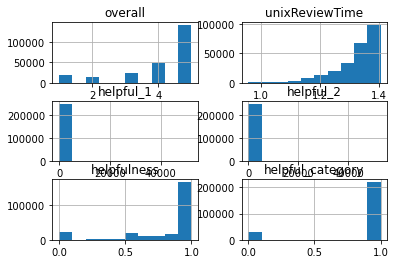

In [78]:
df.hist()

In [79]:
df.helpful_category.value_counts()
# print(len(df["helpfulness"]==1.0))

1    219159
0     29475
Name: helpful_category, dtype: int64

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy import sparse
%matplotlib inline
seed = 42
import os
os.environ['OMP_NUM_THREADS'] = '4'

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [110]:
vect_word = TfidfVectorizer(max_features=20000, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,4),dtype=np.float32)
# vect_char = TfidfVectorizer(max_features=40000, lowercase=True, analyzer='char',
#                         stop_words= 'english',ngram_range=(3,6),dtype=np.float32)

In [111]:
X = np.array(df["reviewText"])
y = np.array(df["helpful_category"])
print(len(X))
print(len(y))
print(type(X))

248634
248634
<class 'numpy.ndarray'>


1
2


/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.20      0.48      0.28     14737
           1       0.91      0.74      0.82    109580

    accuracy                           0.71    124317
   macro avg       0.56      0.61      0.55    124317
weighted avg       0.83      0.71      0.75    124317

1
2


/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.18      0.45      0.26     14738
           1       0.91      0.72      0.80    109579

    accuracy                           0.69    124317
   macro avg       0.54      0.59      0.53    124317
weighted avg       0.82      0.69      0.74    124317



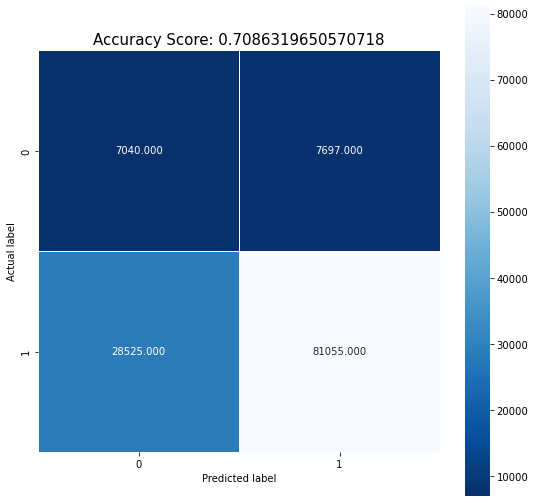

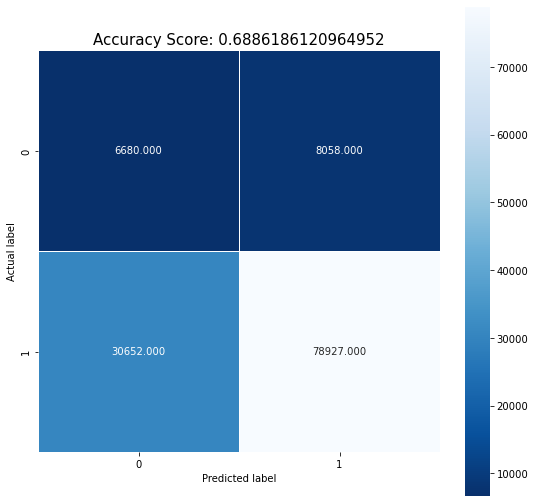

In [113]:
skf = StratifiedKFold(n_splits=2)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("1")
    tr_vect = vect_word.fit_transform(X_train)
    ts_vect = vect_word.transform(X_test)
    print("2")
    
#     tr_vect_char = vect_char.fit_transform(X_train)
#     ts_vect_char = vect_char.transform(X_test)
#     print("2")

#     X = sparse.hstack([tr_vect, tr_vect_char])
#     x_test = sparse.hstack([ts_vect, ts_vect_char])
    X_train = sparse.hstack([tr_vect])
    X_test = sparse.hstack([ts_vect])
    
#     prd = np.zeros((x_test.shape[0],y_train.shape[1]))

    lr = LogisticRegression(C=2,random_state = 42,class_weight = 'balanced')
    lr.fit(X_train,y_train)
    pred =  lr.predict(X_test)
    score = lr.score(X_test, y_test)
    cm = metrics.confusion_matrix(y_test, pred)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);
#     print('\nConfusion matrix\n',confusion_matrix(y_test,pred))
    print(classification_report(y_test,pred))
    